In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
int = pd.read_csv('/content/drive/MyDrive/Stock Price/data/final_final_int.csv')
same = pd.read_csv('/content/drive/MyDrive/Stock Price/data/final_final_same.csv')
int = int.drop(columns=['Unnamed: 0'])
same = same.drop(columns=['Unnamed: 0'])

same['Date'] = pd.to_datetime(same['Date'])
int['Date'] = pd.to_datetime(int['Date'])

same.set_index('Date', inplace=True)
int.set_index('Date', inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Stock Price/data/final_final_int.csv'

In [ ]:
#same.head()
#int.head()
#same.info()

Date  Open  High   Low  Close   Volume    Change  Transaction  \
0  2001-01-02  3160  3380  3140   3350   789127  0.060127   2643575450   
1  2001-01-03  3229  3420  3220   3370   757143  0.005970   2551571910   
2  2001-01-04  3790  3870  3660   3780  2398248  0.121662   9065377440   
3  2001-01-05  3760  3920  3700   3900  1562744  0.031746   6094701600   
4  2001-01-08  3820  3910  3780   3880   845911 -0.005128   3282134680   

   SE_Operating_Profit  SE_Net_Profit  ...  KR_Base  KR_10    WTI  Exchange  \
0         9.070090e+12   6.002880e+12  ...     5.25   7.18  27.21    1276.4   
1         9.079520e+12   6.002880e+12  ...     5.25   7.15  28.00    1270.1   
2         9.088620e+12   6.002880e+12  ...     5.25   6.85  28.14    1255.0   
3         9.097401e+12   6.002880e+12  ...     5.25   6.68  27.95    1263.5   
4         9.121873e+12   6.002880e+12  ...     5.25   6.60  27.32    1265.8   

   SOX_Close     Phone  KR_Unemployment  US_President  KR_President  Covid19  
0      570.3  7.114173         4.409677           1.0           1.0        0  
1      670.2  7.128294         4.419355           1.0           1.0        0  
2      653.8  7.142364         4.429032           1.0           1.0        0  
3      617.5  7.156383         4.438710           1.0           1.0        0  
4      634.2  7.198134         4.467742           1.0           1.0        0  

[5 rows x 34 columns]

# KNN-same

In [ ]:
from sklearn.neighbors import NearestNeighbors

def outlier_knn(data, n_neighbors=5, outlier_fraction=0.05):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(data)
    distances, indices = nbrs.kneighbors(data)
    mean_distance = distances[:, 1:].mean(axis=1)
    threshold = np.percentile(mean_distance, 100 * (1 - outlier_fraction))
    is_outlier = mean_distance > threshold
    outliers = data[is_outlier]
    return outliers, is_outlier, mean_distance, threshold

In [ ]:
def plot_knn(dict, data, x_size, y_size, path, grid_flag=False):
    date = data.index
    fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(x_size, y_size))
    axes = axes.flatten()

    for i, feature in enumerate(data.columns):
        feat = data[feature]
        # Series를 DataFrame으로 변환
        outliers, is_outlier, mean_distance, threshold = outlier_knn(feat.to_frame())
        dict[f'{feat.name}'] = outliers

        ax = axes[i]
        label = f'{feat.name}'
        ax.scatter(date, feat, marker='o', label=label, s = 5)

        if not outliers.empty:
            ax.scatter(date[is_outlier], feat[is_outlier], color='red', marker='x', s=5, label='Outliers', zorder=5)

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

        ax.set_title(f'KNNOutliers - {feat.name}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(grid_flag)

        if not outliers.empty:  # 아웃라이어가 있는 경우에만 legend 추가
            ax.legend()

    plt.tight_layout()
    plt.savefig(path)
    plt.show()


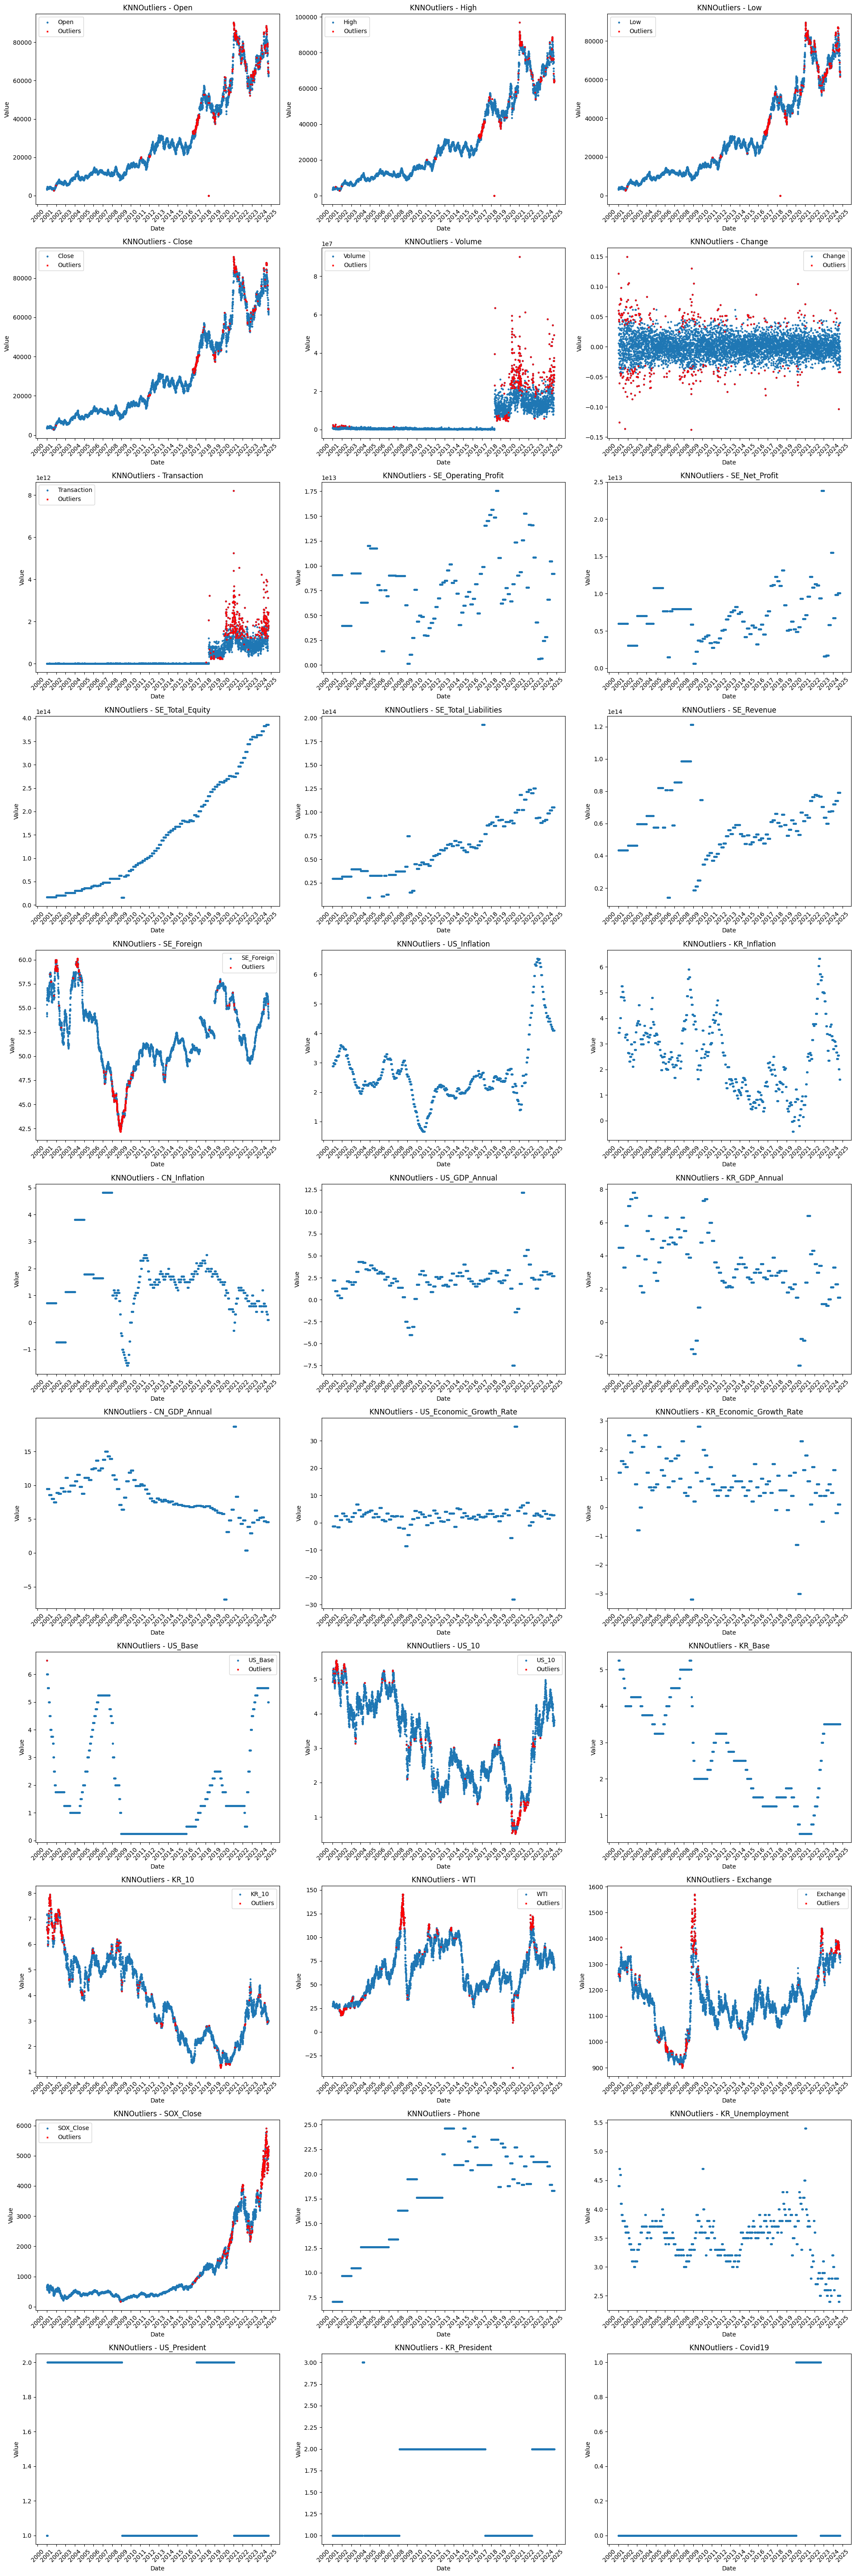

In [ ]:
path = '/content/drive/MyDrive/Stock Price/dataknn01.jpg'
knn_dict = {}
plot_knn(knn_dict, same, 20, 60, path)

# KNN-Interpolation

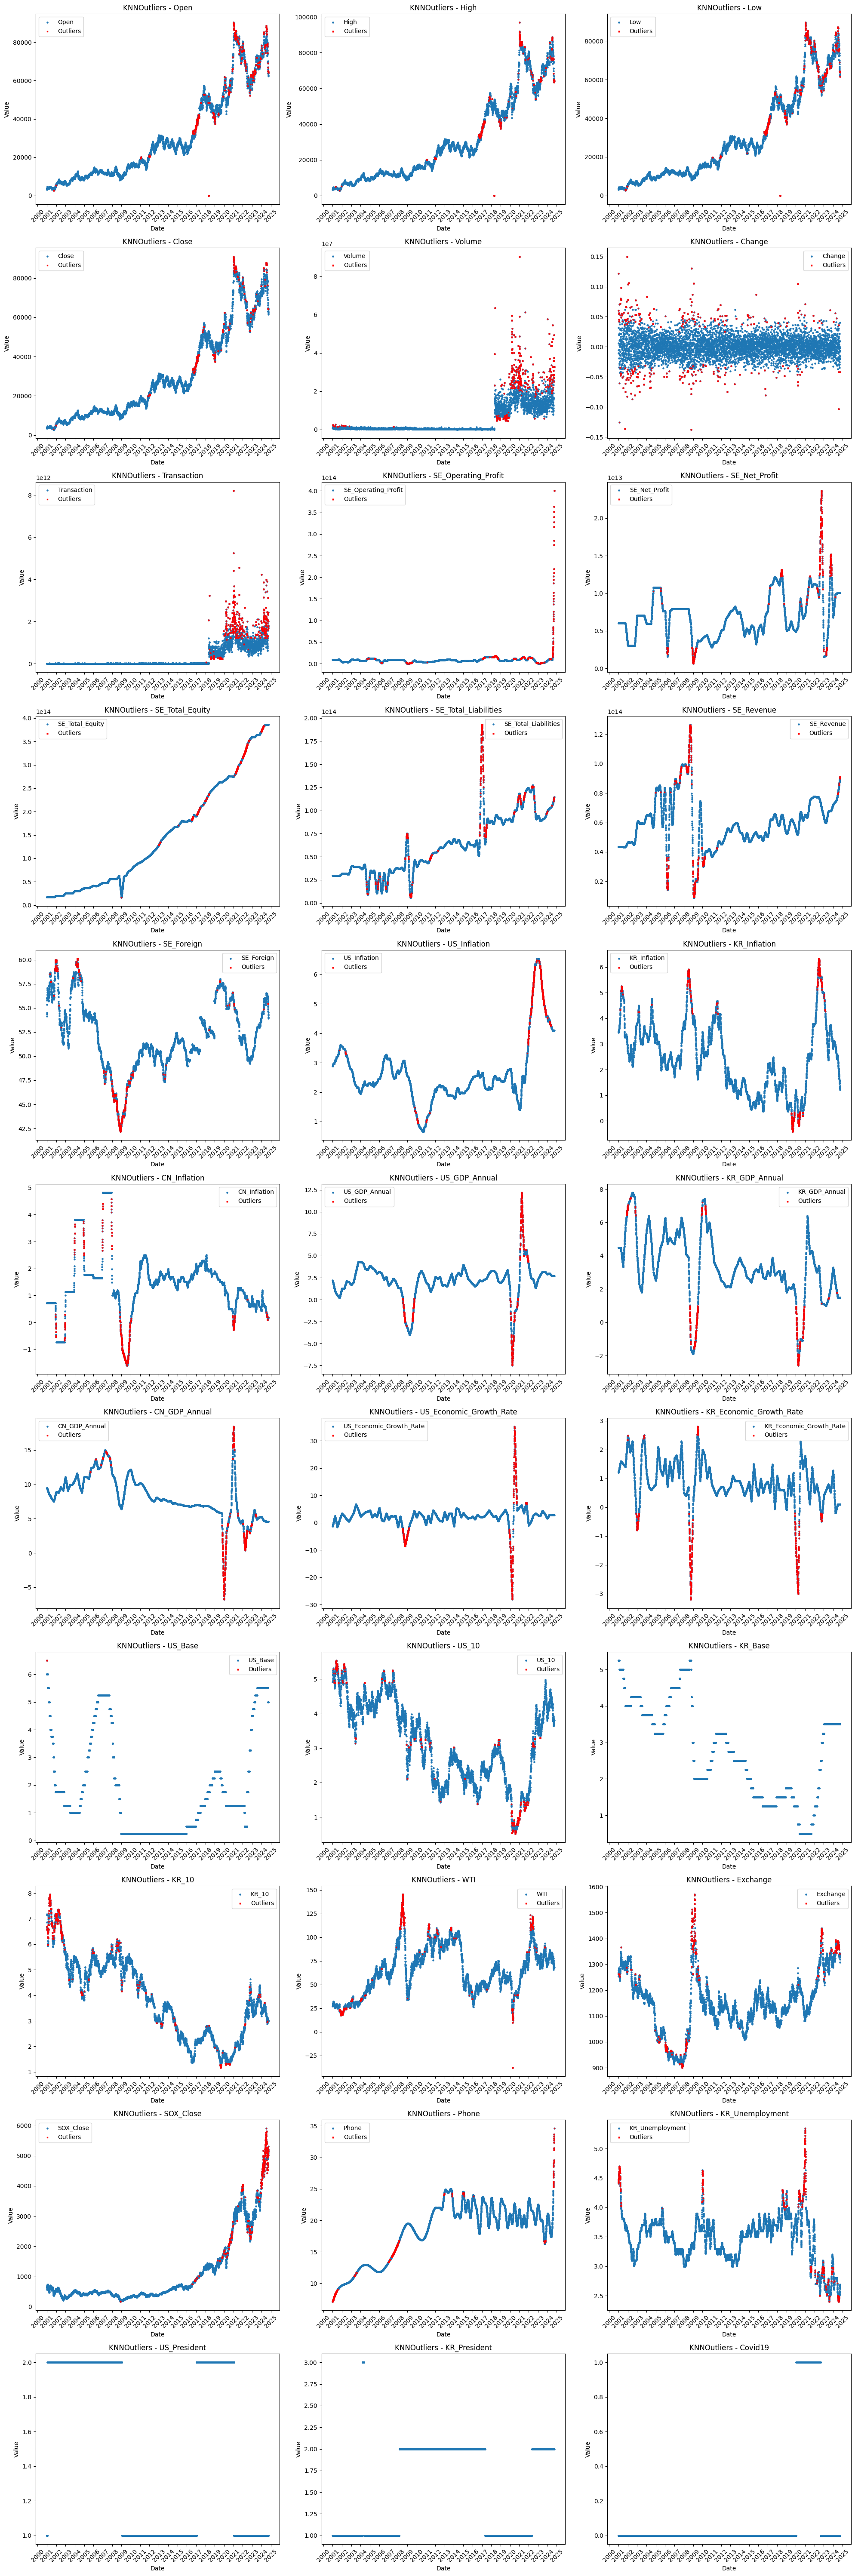

In [ ]:
path = '/content/drive/MyDrive/Stock Price/dataknn01.jpg'
knn_dict = {}
plot_knn(knn_dict, int, 20, 60, path)

# **Final**

In [ ]:
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # IQR 범위로 이상치 값 제한
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df




def handle_outliers_zscore(df, column, threshold=3):
    # Z-Score 계산
    df['zscore'] = zscore(df[column], nan_policy='omit')  # 결측치 무시
    # 이상치 여부 판별 및 결측치로 변환
    df[column] = df.apply(lambda row: np.nan if abs(row['zscore']) > threshold else row[column], axis=1)
    # 결측치 보간 및 앞뒤 채우기
    df[column] = df[column].interpolate(method='linear').bfill().ffill()
    # zscore 열 삭제
    df.drop(columns=['zscore'], inplace=True)
    return df

def handle_outliers_modified_zscore(df, column, threshold=3.5):
    # 중앙값 및 MAD 계산
    median = df[column].median()
    mad = (np.abs(df[column] - median)).median()

    # 수정된 Z-Score 계산
    df['modified_zscore'] = 0.6745 * (df[column] - median) / mad

    # 이상치 여부 판별 및 결측치로 변환
    df[column] = df.apply(lambda row: np.nan if abs(row['modified_zscore']) > threshold else row[column], axis=1)

    # 결측치 보간 및 앞뒤 채우기
    df[column] = df[column].interpolate(method='linear').bfill().ffill()

    # modified_zscore 열 삭제
    df.drop(columns=['modified_zscore'], inplace=True)

    return df



def winsorize_column(df, column, limits=(0.01, 0.01)):
    # 상하위 1% 값을 Winsorizing
    df[column] = winsorize(df[column], limits=limits)
    return df

def quantile_clipping(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    # 상하위 퍼센타일 범위로 값 제한
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

def plot_outlier_handling(df_original, df_handled, columns, method_name, figsize=(20, 12), save_path=None, grid_flag=False):
    """
    아웃라이어 처리 전후 데이터를 시각화
    Parameters:
        df_original: DataFrame - 원본 데이터
        df_handled: DataFrame - 아웃라이어 처리된 데이터
        columns: list - 처리한 열 이름 리스트
        method_name: str - 처리 방법명 (e.g., IQR, Z-Score)
        figsize: tuple - 플롯 크기
        save_path: str - 결과 저장 경로
        grid_flag: bool - 그리드 표시 여부
    """
    date = df_original.index
    n_features = len(columns)
    n_cols = 4  # 한 행에 그릴 플롯 수
    n_rows = (n_features + n_cols - 1) // n_cols  # 행 수 계산

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]

        # 원본 데이터와 처리된 데이터 플롯
        ax.plot(date, df_original[column], label=f'Original {column}', alpha=0.7, linestyle='--')
        ax.plot(date, df_handled[column], label=f'Handled {column}', alpha=0.9)

        # 축 및 레이블 설정
        ax.set_title(f'{method_name} - {column}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.tick_params(axis='x', rotation=45)
        if grid_flag:
            ax.grid(True)
        ax.legend()

    # 남은 빈 플롯 비활성화
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    # 결과 저장 또는 화면 표시
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

In [ ]:
df_handled.to_csv('df_handled.csv', index=False)

## Same Version

In [ ]:
# 데이터 준비
df_original = same.copy()  # 원본 데이터
df_handled = same.copy()   # 아웃라이어 처리 후 데이터

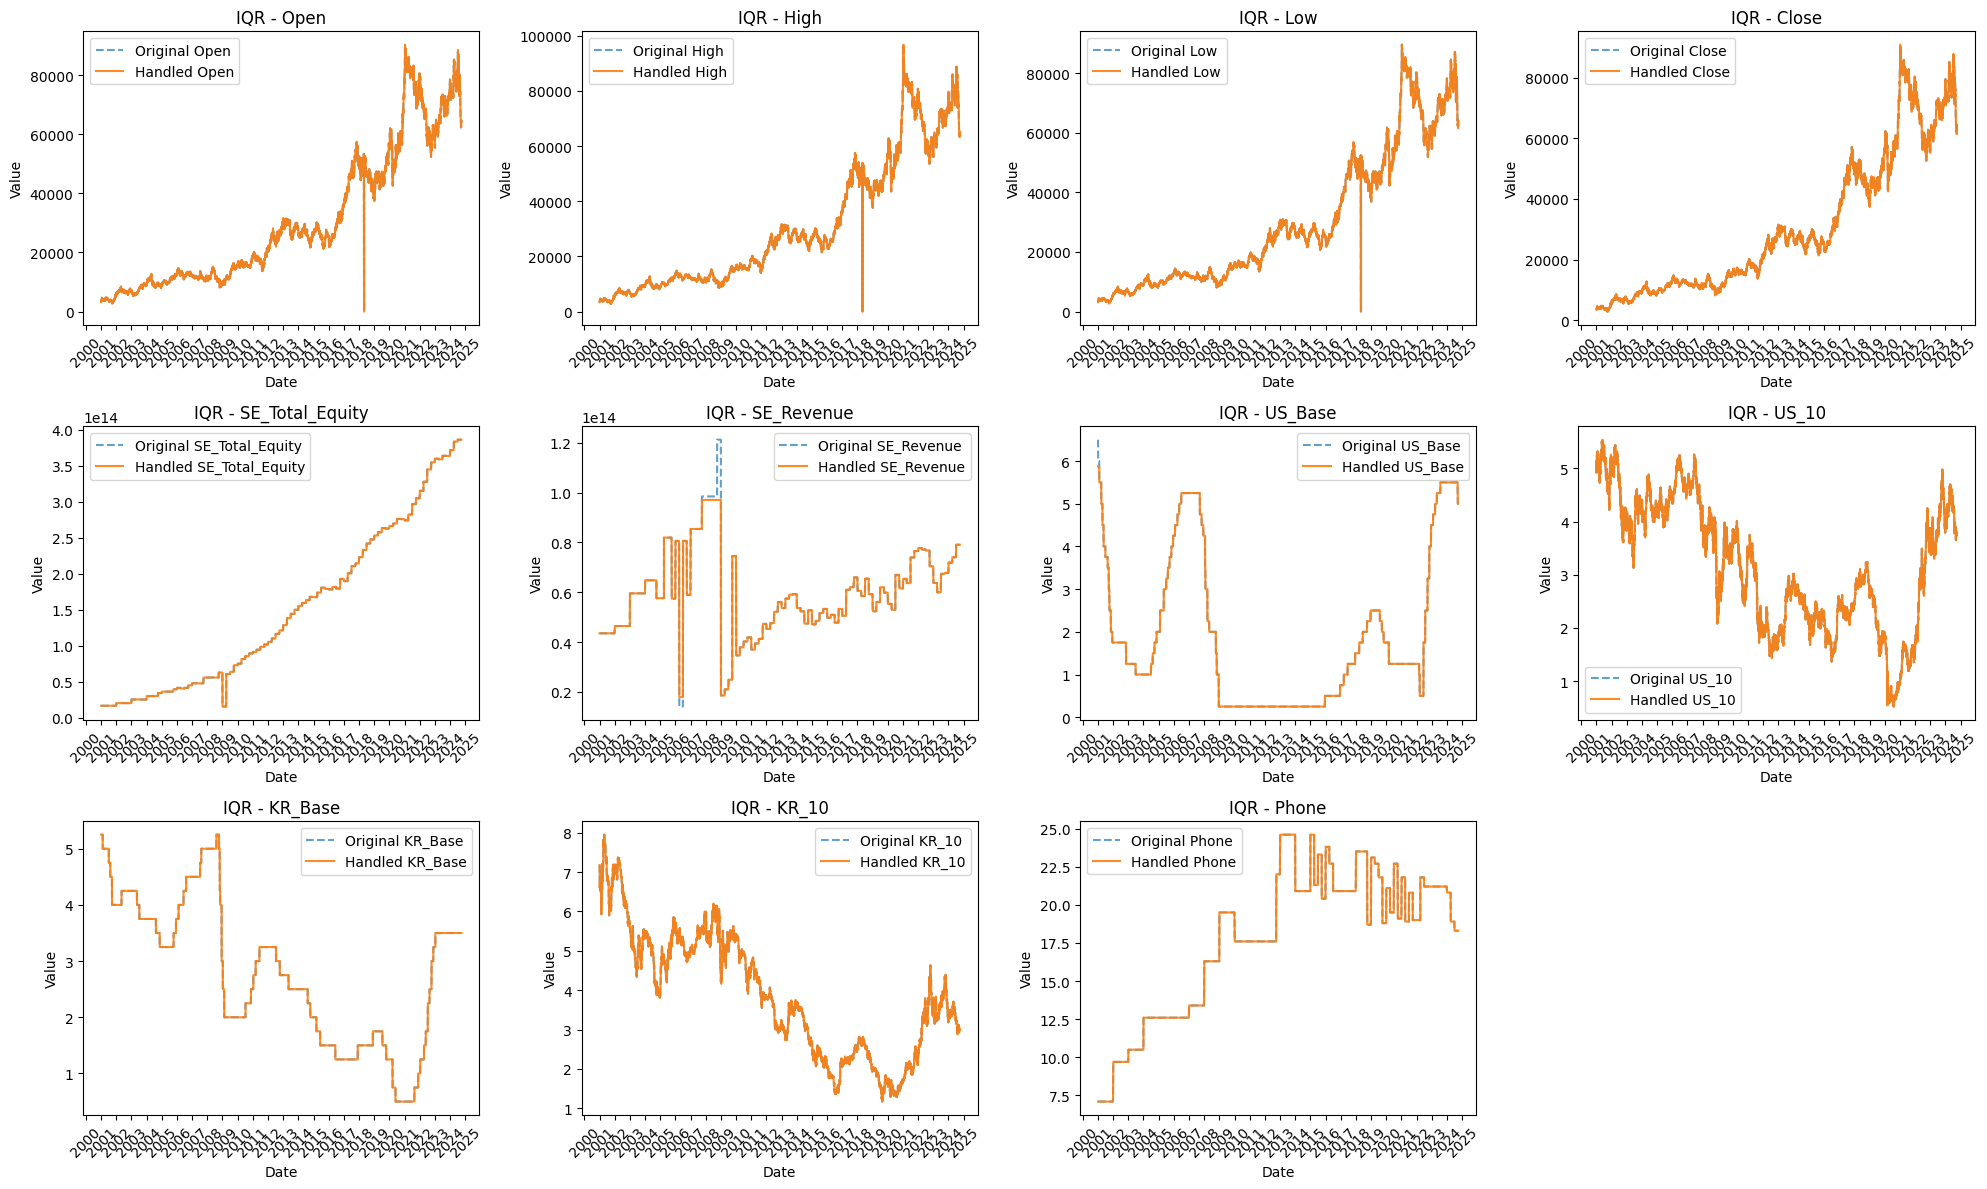

In [ ]:
# IQR 방식 시각화
columns_iqr = ['Open', 'High', 'Low', 'Close', 'SE_Total_Equity', 'SE_Revenue',
               'US_Base', 'US_10', 'KR_Base', 'KR_10', 'Phone', 'BB_High', 'BB_Low', 'RSI',
                'High_Low_Volatility', 'Lag_1', 'Lag_30', 'Lag_60', 'Lag_90']
for col in columns_iqr:
    df_handled = handle_outliers_iqr(df_handled, col)
plot_outlier_handling(df_original, df_handled, columns_iqr, method_name="IQR", save_path="iqr_outliers.png")

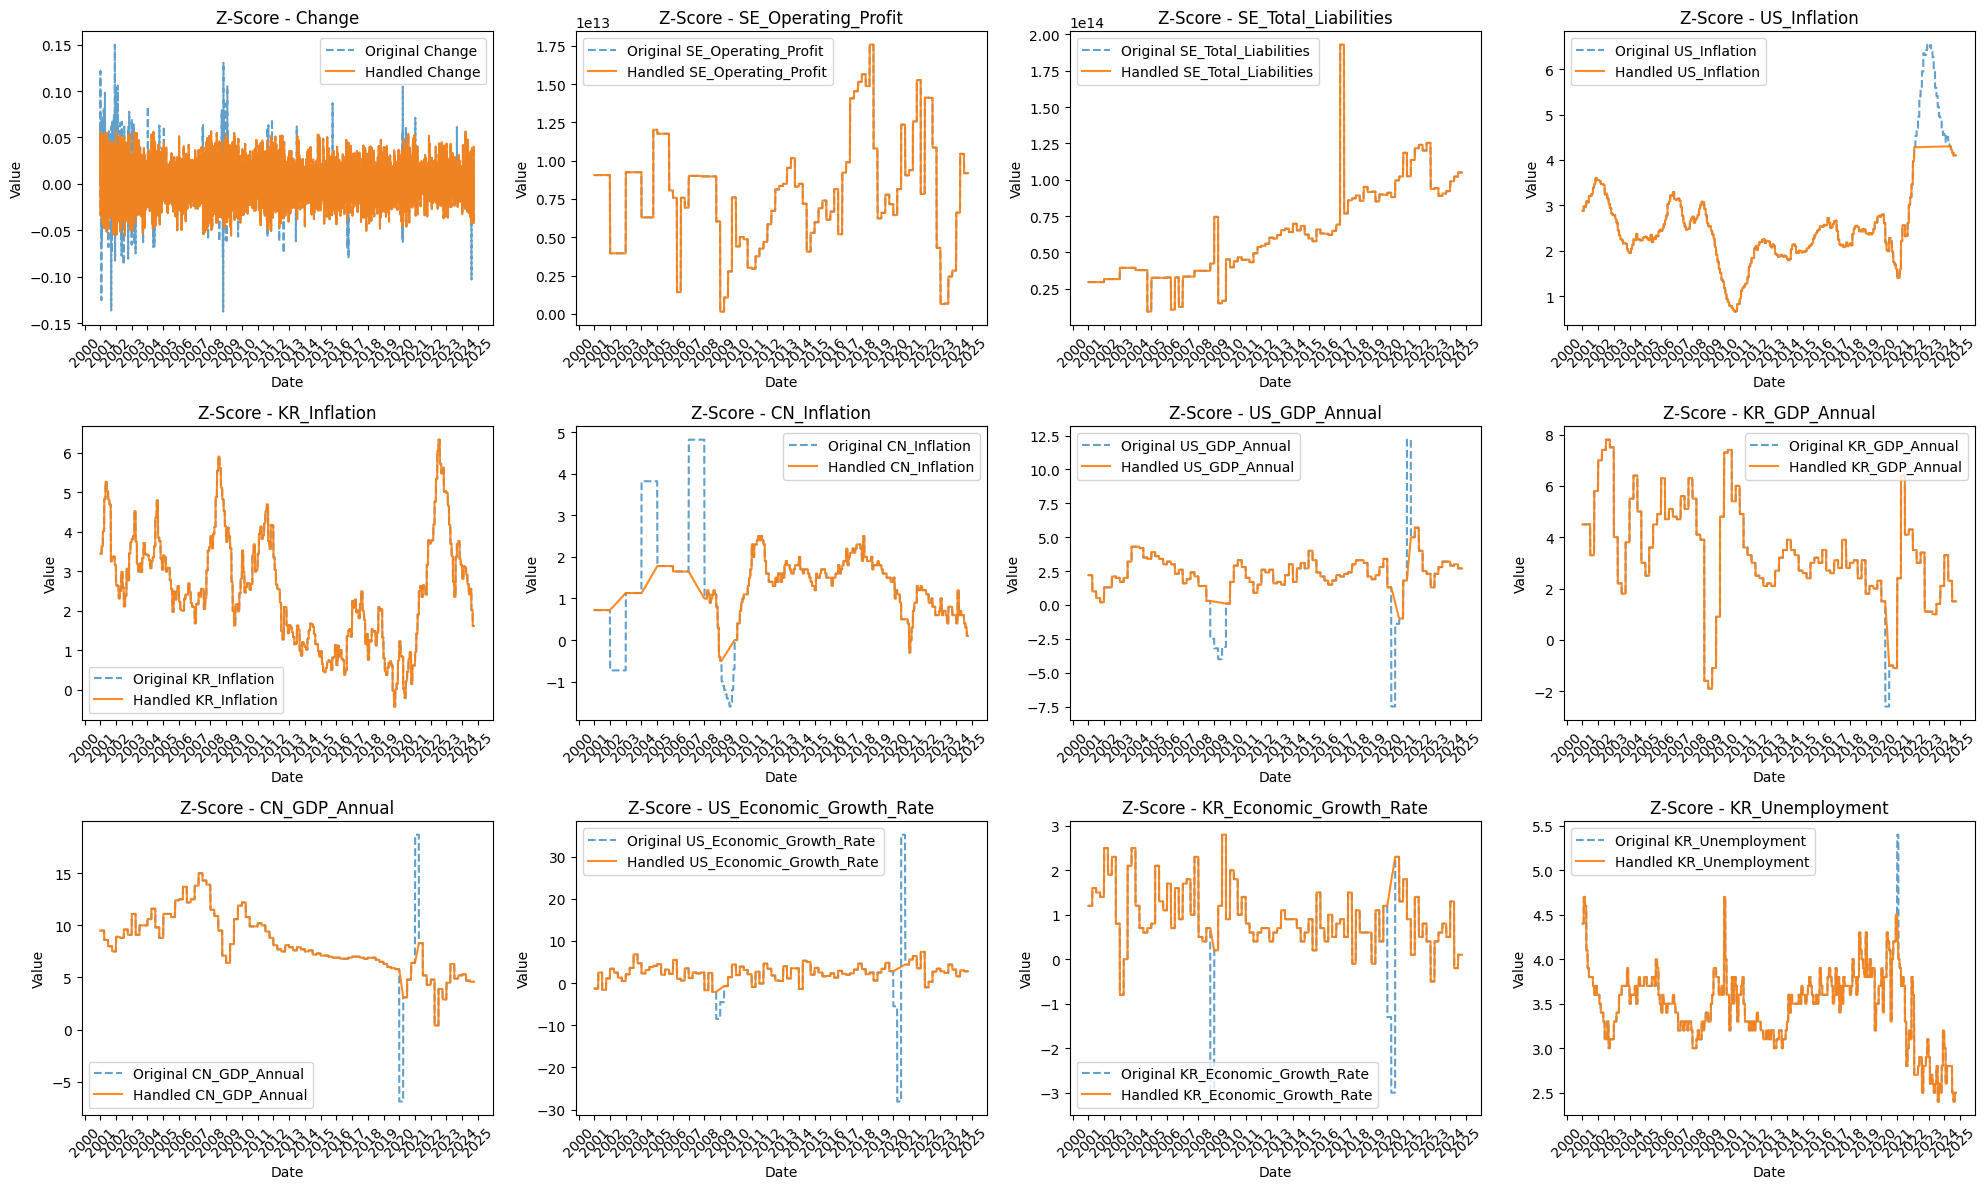

In [ ]:
# Z-Score 방식 시각화
columns_zscore = ['Change', 'SE_Operating_Profit', 'SE_Total_Liabilities',
                  'US_Inflation', 'KR_Inflation', 'CN_Inflation',
                  'US_GDP_Annual', 'KR_GDP_Annual', 'CN_GDP_Annual',
                  'US_Economic_Growth_Rate', 'KR_Economic_Growth_Rate',
                  'KR_Unemployment']
for col in columns_zscore:
    df_handled = handle_outliers_modified_zscore(df_handled, col)
plot_outlier_handling(df_original, df_handled, columns_zscore, method_name="Z-Score", save_path="zscore_outliers.png")

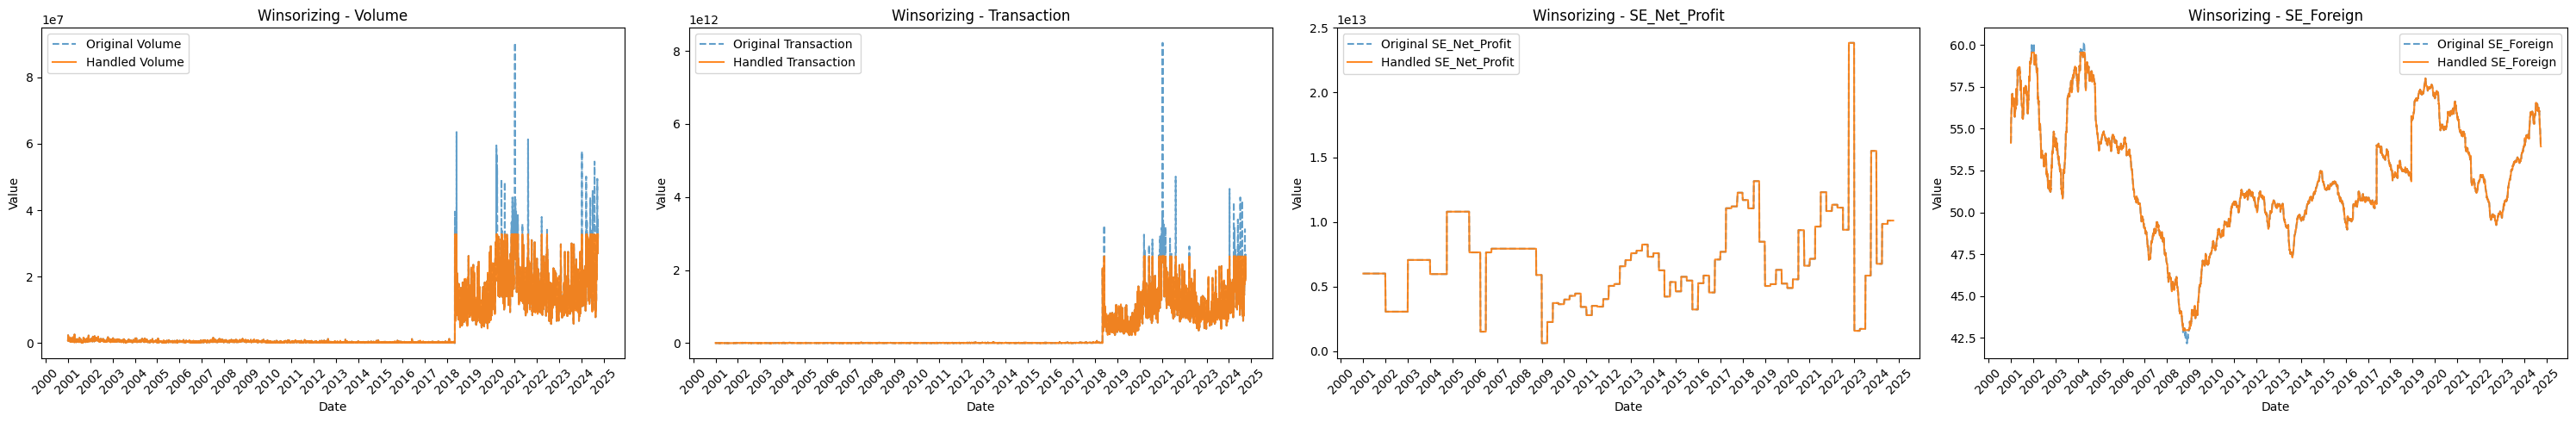

In [ ]:
# Winsorizing 방식 시각화
columns_winsorize = ['Volume', 'Transaction', 'SE_Net_Profit', 'SE_Foreign', 'Volume_Price_Ratio', 'Volume_Momentum']
for col in columns_winsorize:
    df_handled = winsorize_column(df_handled, col)
plot_outlier_handling(df_original, df_handled, columns_winsorize, figsize = (30,5), method_name="Winsorizing", save_path="winsorizing_outliers.png")

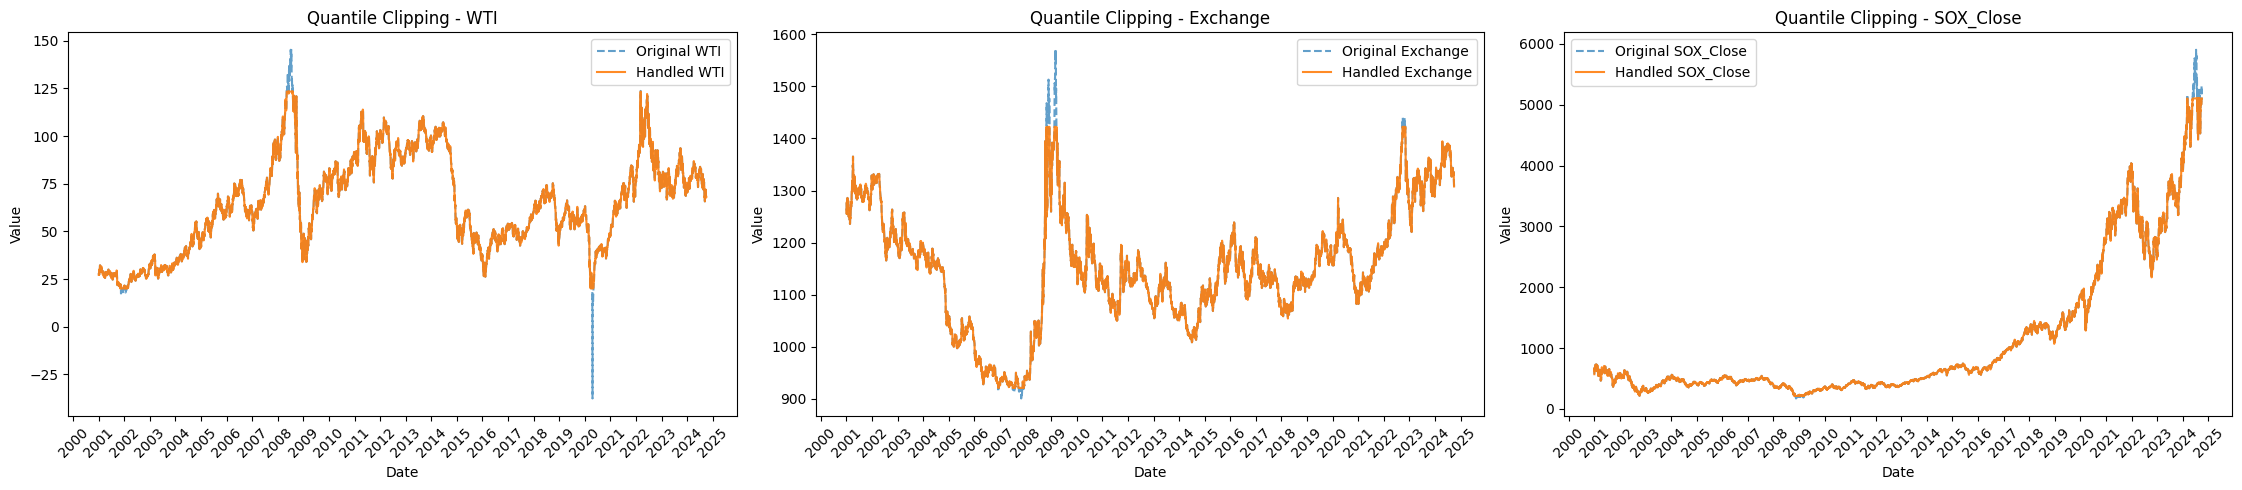

In [ ]:
# Quantile Clipping 방식 시각화
columns_quantile = ['WTI', 'Exchange', 'SOX_Close']
for col in columns_quantile:
    df_handled = quantile_clipping(df_handled, col)
plot_outlier_handling(df_original, df_handled, columns_quantile, figsize = (30,5), method_name="Quantile Clipping", save_path="quantile_clipping_outliers.png")

## Interpolation Version

In [ ]:
# 데이터 준비
df_original_int = int.copy()  # 원본 데이터
df_handled_int = int.copy()   # 아웃라이어 처리 후 데이터

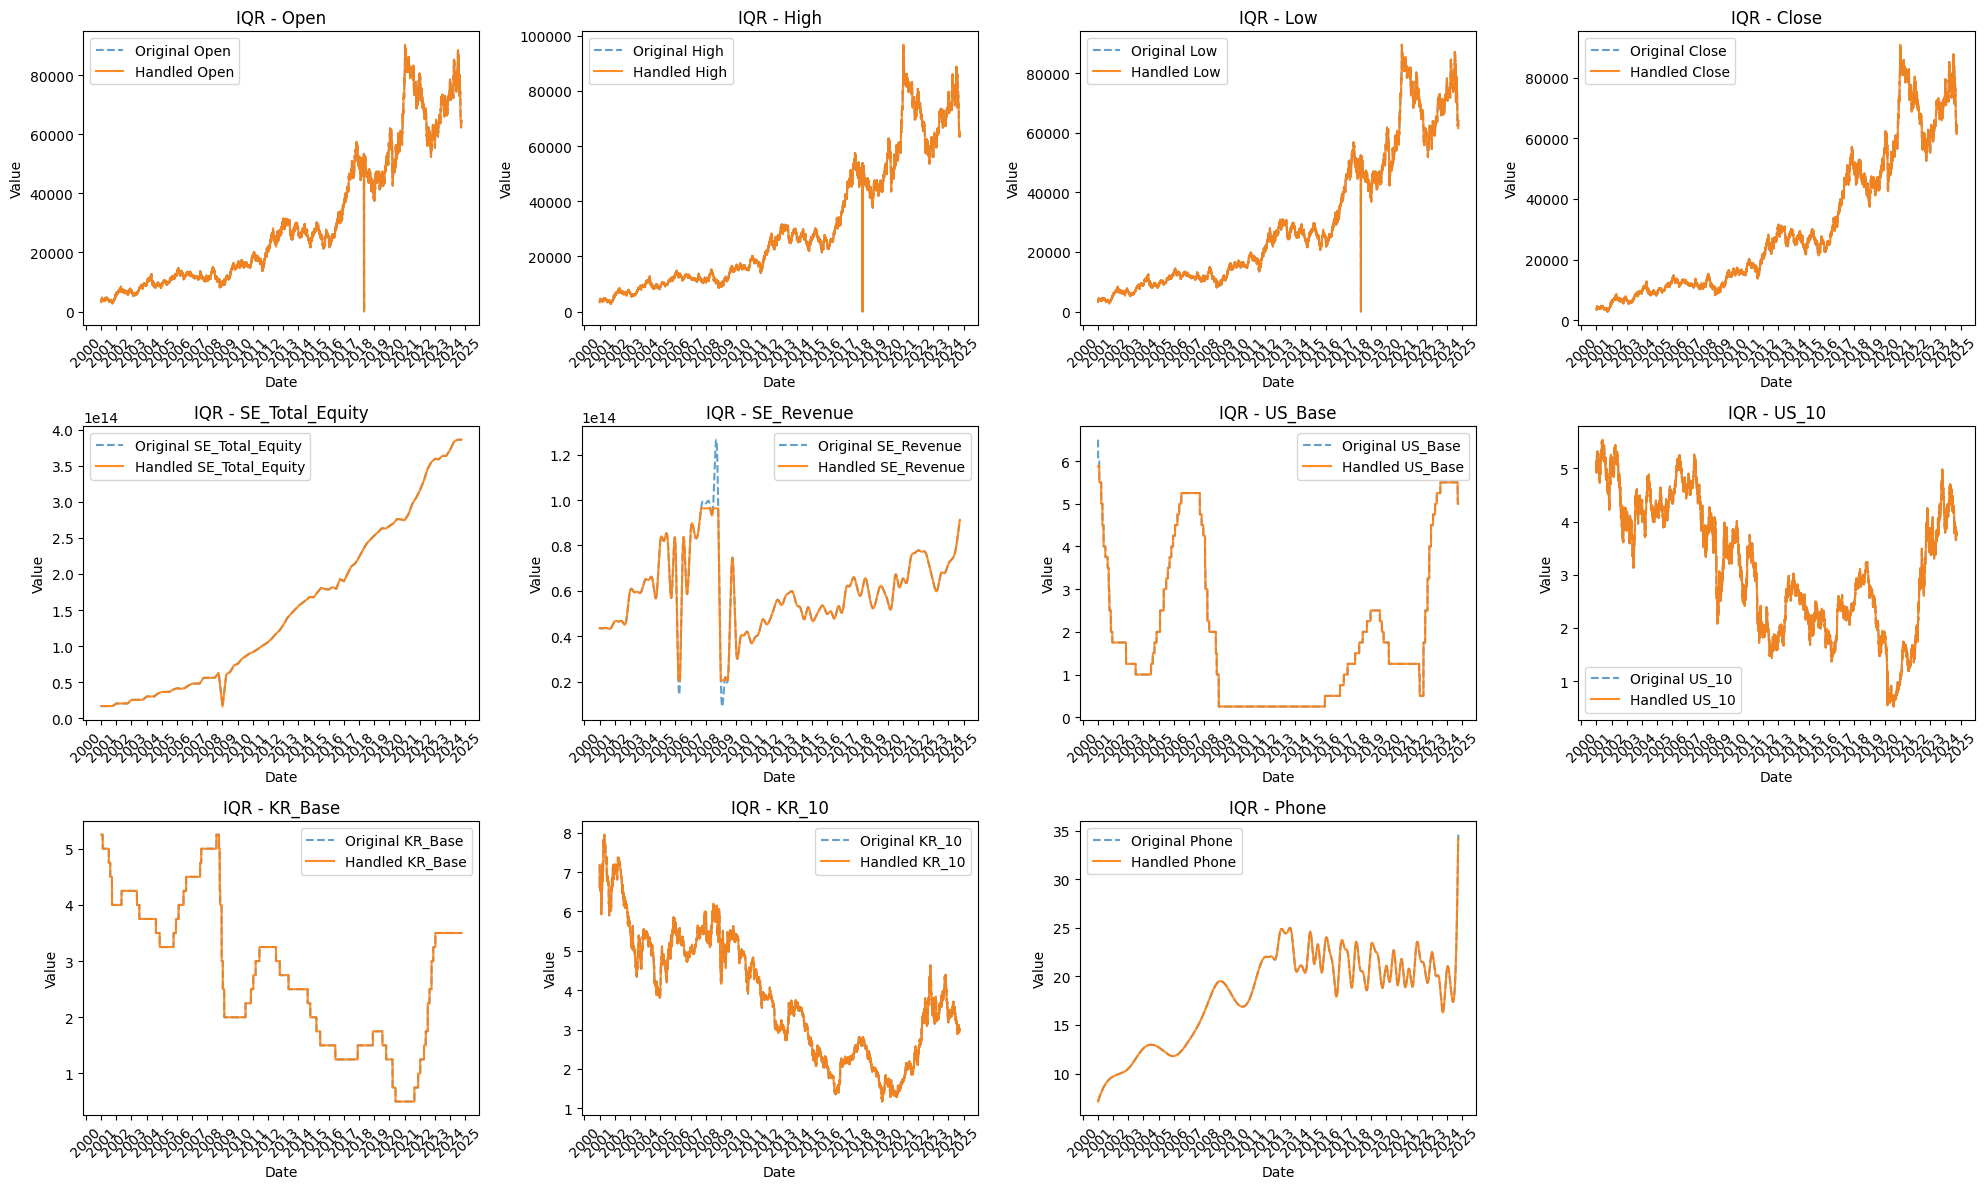

In [ ]:
# IQR 방식 시각화
columns_iqr = ['Open', 'High', 'Low', 'Close', 'SE_Total_Equity', 'SE_Revenue',
               'US_Base', 'US_10', 'KR_Base', 'KR_10', 'Phone''BB_High', 'BB_Low', 'RSI',
                'High_Low_Volatility', 'Lag_1', 'Lag_30', 'Lag_60', 'Lag_90']
for col in columns_iqr:
    df_handled_int = handle_outliers_iqr(df_handled_int, col)
plot_outlier_handling(df_original_int, df_handled_int, columns_iqr, method_name="IQR", save_path="iqr_outliers_int.png")

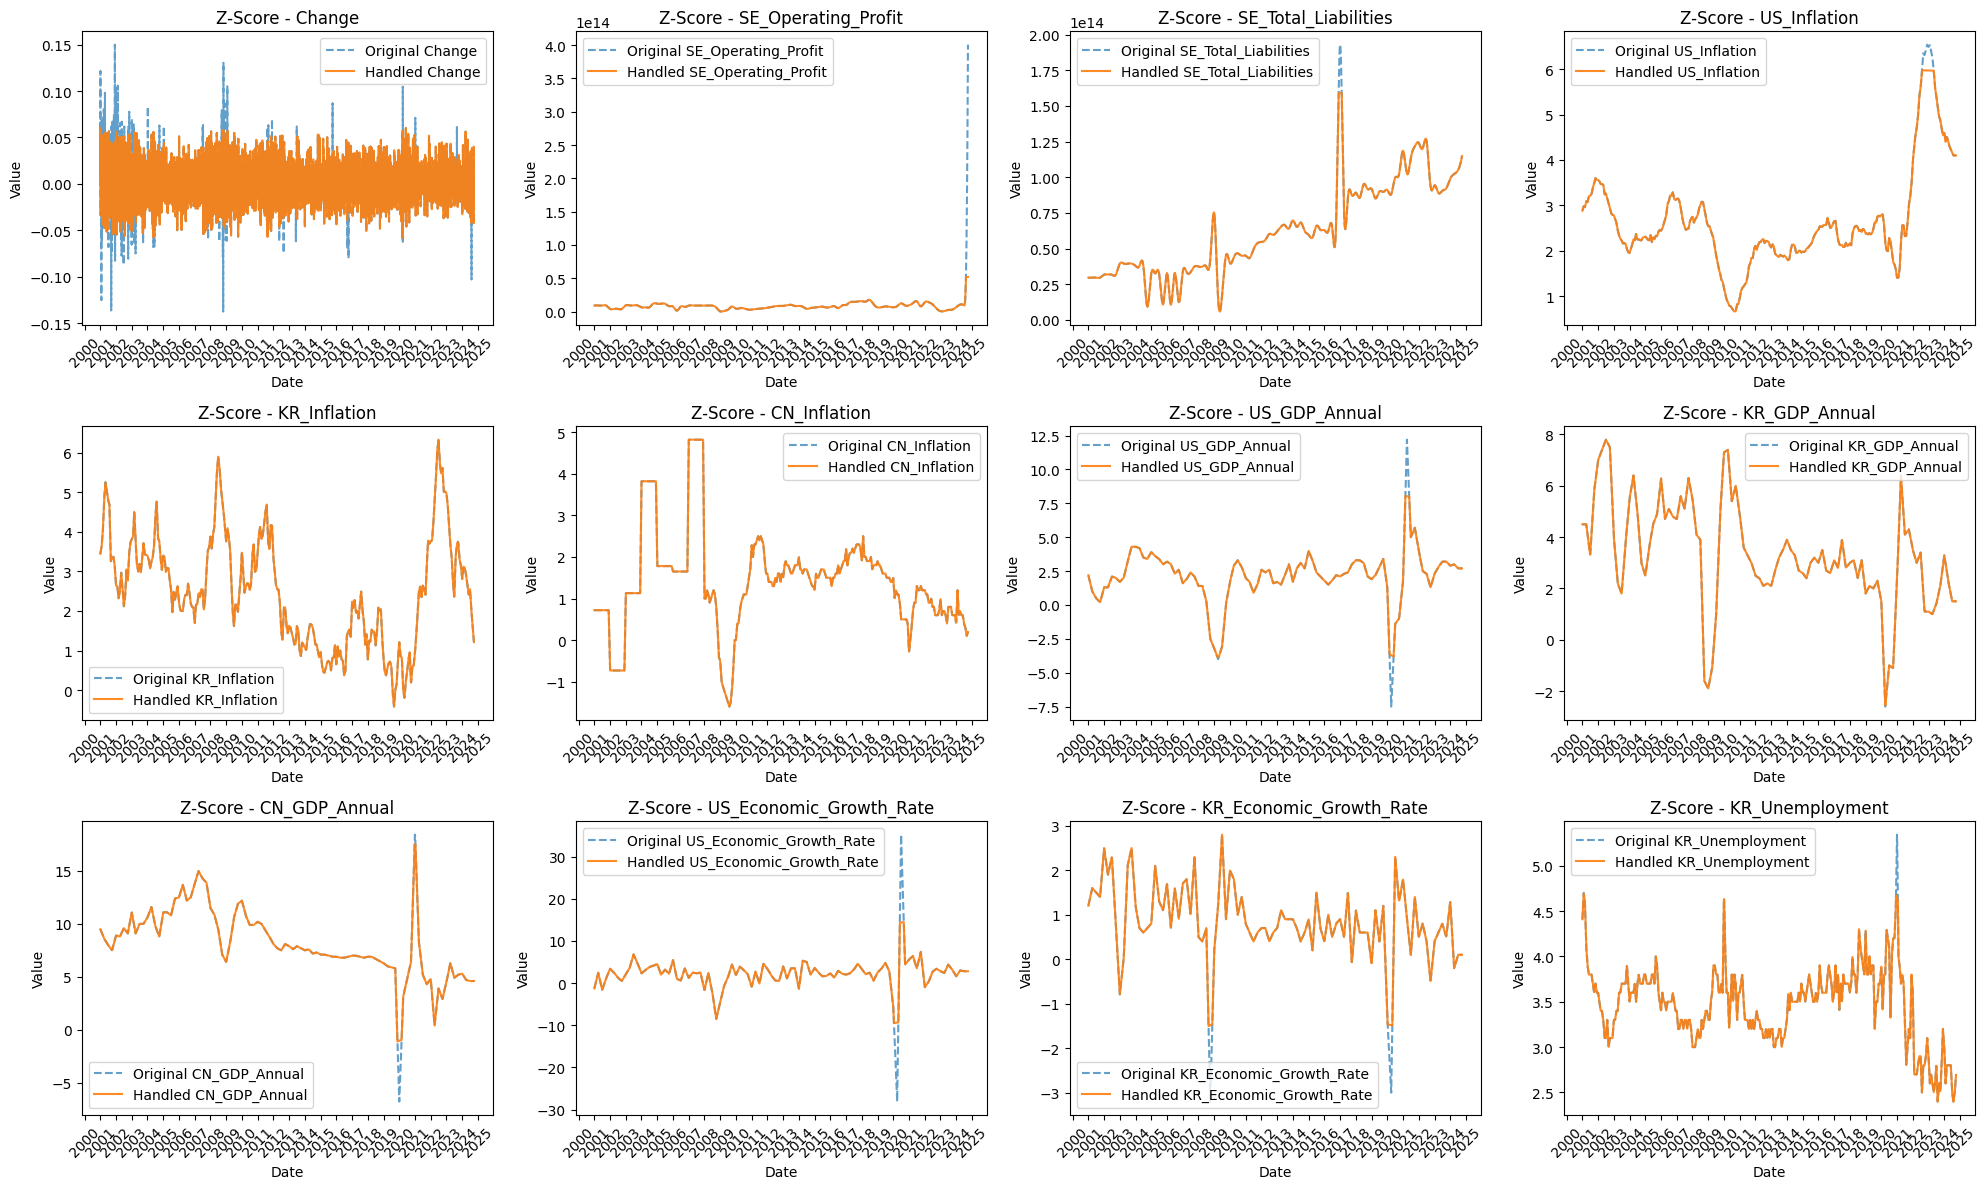

In [ ]:
# Z-Score 방식 시각화
columns_zscore = ['Change', 'SE_Operating_Profit', 'SE_Total_Liabilities',
                  'US_Inflation', 'KR_Inflation', 'CN_Inflation',
                  'US_GDP_Annual', 'KR_GDP_Annual', 'CN_GDP_Annual',
                  'US_Economic_Growth_Rate', 'KR_Economic_Growth_Rate',
                  'KR_Unemployment']
for col in columns_zscore:
    df_handled_int = handle_outliers_zscore(df_handled_int, col)
plot_outlier_handling(df_original_int, df_handled_int, columns_zscore, method_name="Z-Score", save_path="zscore_outliers_int.png")

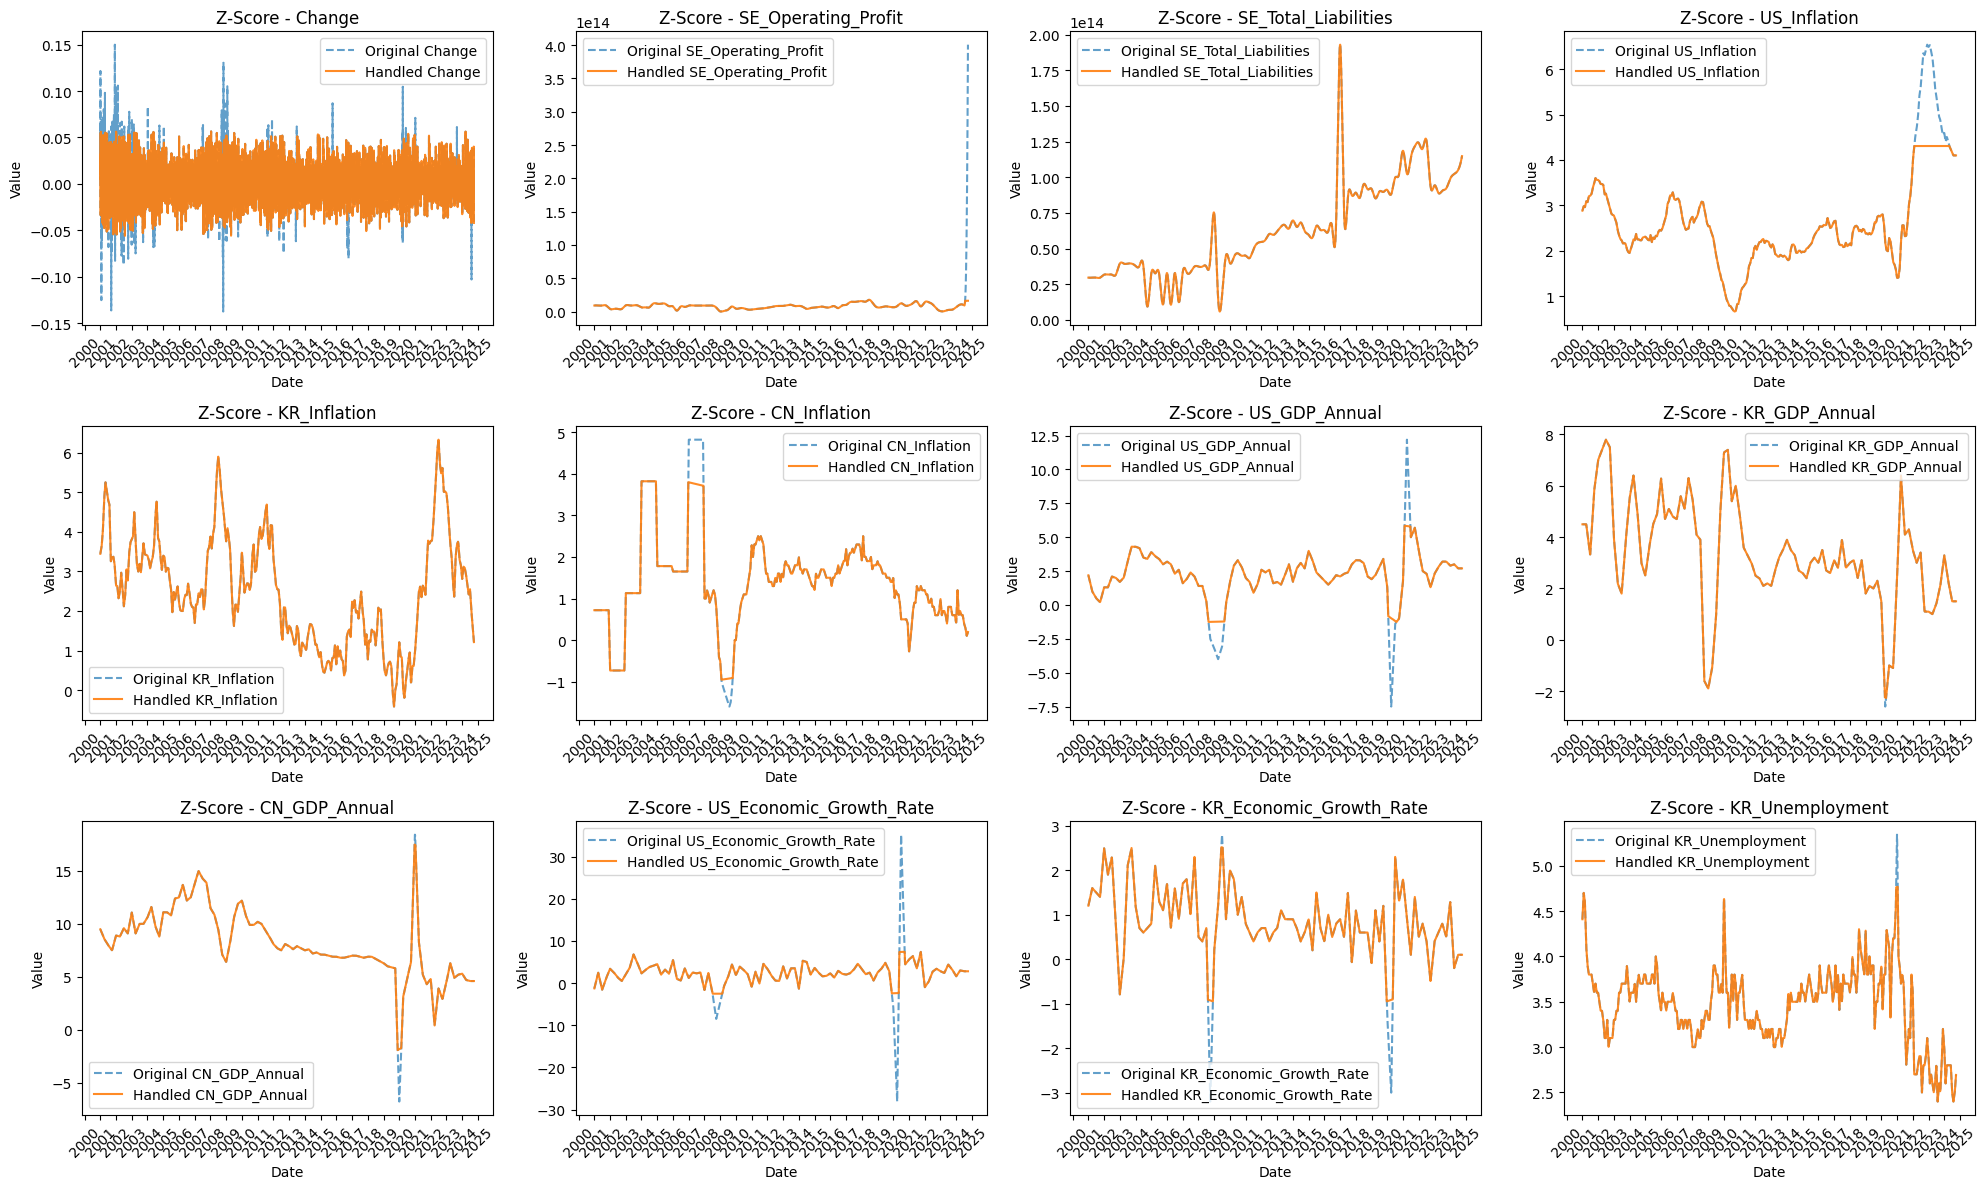

In [ ]:
# 수정된 Z-Score 방식 시각화
columns_zscore = ['Change', 'SE_Operating_Profit', 'SE_Total_Liabilities',
                  'US_Inflation', 'KR_Inflation', 'CN_Inflation',
                  'US_GDP_Annual', 'KR_GDP_Annual', 'CN_GDP_Annual',
                  'US_Economic_Growth_Rate', 'KR_Economic_Growth_Rate',
                  'KR_Unemployment']
for col in columns_zscore:
    df_handled_int = handle_outliers_modified_zscore(df_handled_int, col)
plot_outlier_handling(df_original_int, df_handled_int, columns_zscore, method_name="Z-Score", save_path="zscore_outliers_int.png")

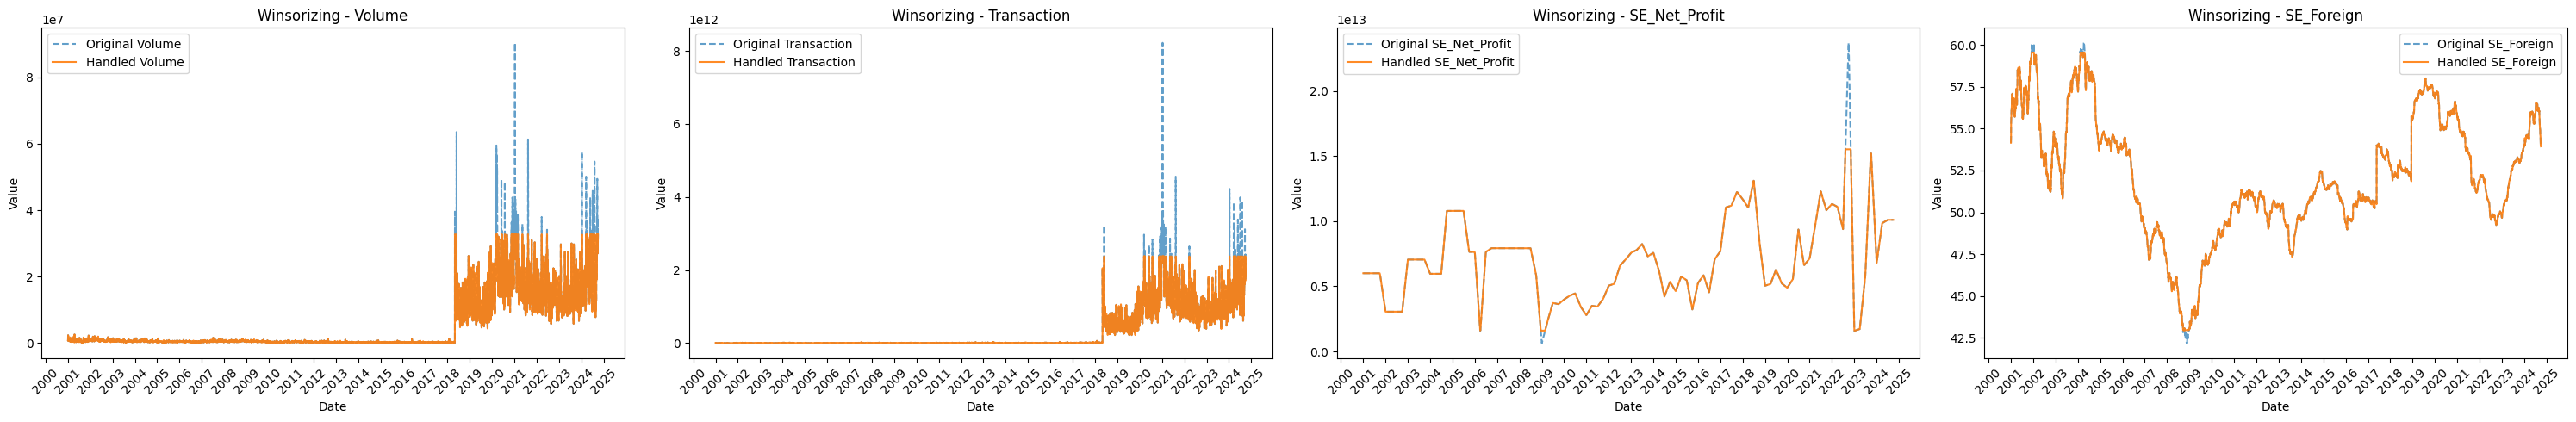

In [ ]:
# Winsorizing 방식 시각화
columns_winsorize = ['Volume', 'Transaction', 'SE_Net_Profit', 'SE_Foreign', 'Volume_Price_Ratio', 'Volume_Momentum']
for col in columns_winsorize:
    df_handled_int = winsorize_column(df_handled_int, col)
plot_outlier_handling(df_original_int, df_handled_int, columns_winsorize, figsize = (30,5), method_name="Winsorizing", save_path="winsorizing_outliers_int.png")

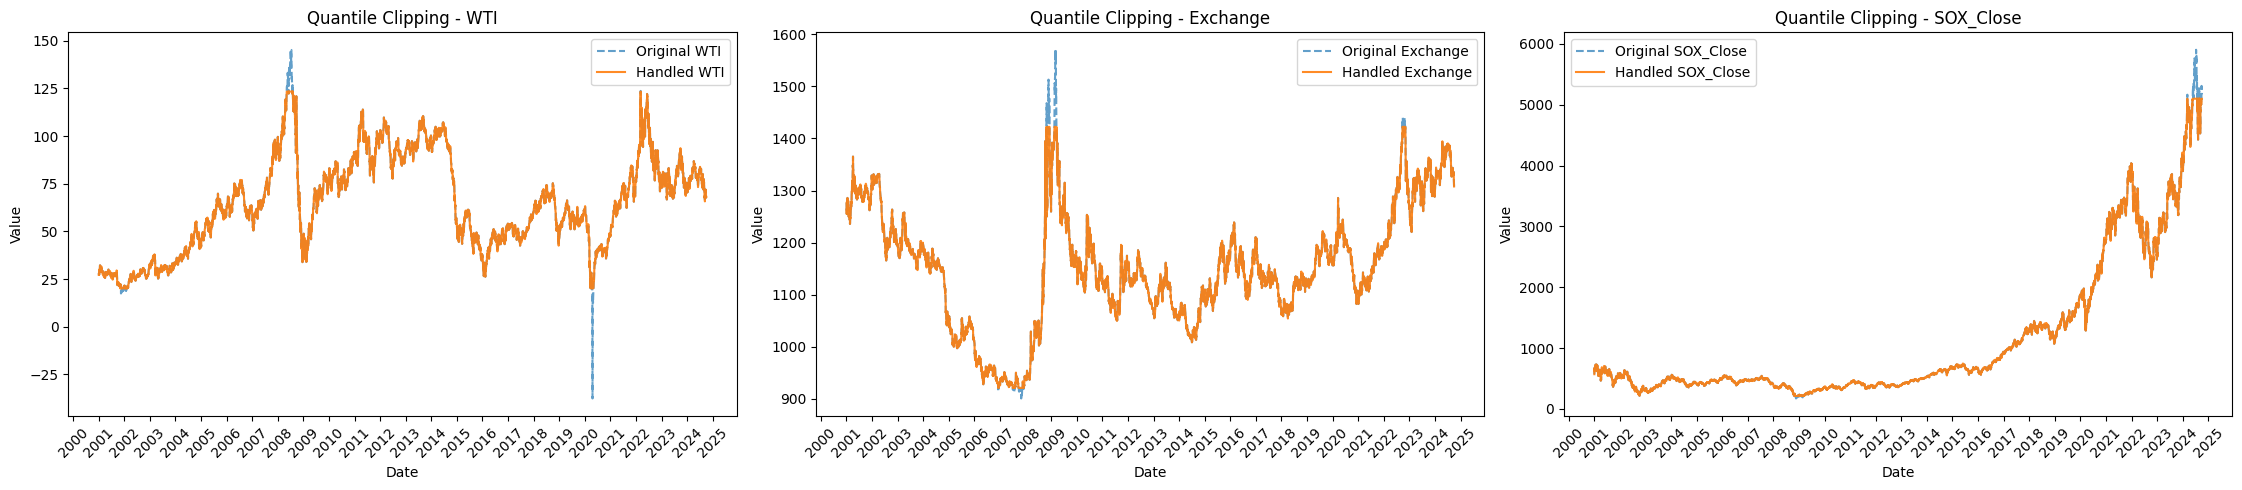

In [ ]:
# Quantile Clipping 방식 시각화
columns_quantile = ['WTI', 'Exchange', 'SOX_Close']
for col in columns_quantile:
    df_handled_int = quantile_clipping(df_handled_int, col)
plot_outlier_handling(df_original_int, df_handled_int, columns_quantile, figsize = (30,5), method_name="Quantile Clipping", save_path="quantile_clipping_outliers_int.png")

## 아웃라이어 처리 이유

이유: 논리적 관계(Low <= Open <= Close <= High)가 중요한 단변량 데이터.
처리:
IQR로 극단값 감지.
논리적 관계 위반 시 상/하위 값으로 조정.
python
코드 복사


In [ ]:
### 시가 종가 저가 고가

def process_price_data(df, column):
    # IQR 기반 이상치 처리
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 이상치를 상/하위 값으로 조정
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# 적용
for col in ['Open', 'High', 'Low', 'Close']:
    data = process_price_data(data, col)


거래 데이터 (Volume, Transaction)
방법: Isolation Forest
이유: 거래량과 거래금액은 정규분포를 따르지 않으며, 특정 이벤트로 인해 급격히 변동 가능.
처리:
Isolation Forest로 이상치를 감지.
이상치는 중앙값으로 대체.

In [ ]:
from sklearn.ensemble import IsolationForest

def process_transaction_data(df, columns, contamination=0.01):
    model = IsolationForest(contamination=contamination, random_state=42)
    anomalies = model.fit_predict(df[columns])
    df['anomaly'] = anomalies
    for col in columns:
        median_value = df[df['anomaly'] != -1][col].median()
        df.loc[df['anomaly'] == -1, col] = median_value
    df.drop(columns=['anomaly'], inplace=True)
    return df

# 적용
data = process_transaction_data(data, ['Volume', 'Transaction'])


change >> zscore

이유: Change는 일반적으로 ±10% 변동률을 초과하지 않음.


처리:
z-score가 3을 초과하는 값을 탐지.
이상치는 이동 평균으로 대체.
python
코드 복사


In [ ]:
from scipy.stats import zscore

def process_change_data(df, column, threshold=3):
    df['zscore'] = zscore(df[column])
    mean_rolling = df[column].rolling(window=5, min_periods=1).mean()
    df[column] = df.apply(lambda x: mean_rolling if abs(x['zscore']) > threshold else x[column], axis=1)
    df.drop(columns=['zscore'], inplace=True)
    return df

# 적용
data = process_change_data(data, 'Change')


거시경제 지표 (Inflation, GDP_Annual, Base, KR_10, US_10)
방법: Winsorizing
이유: 거시 지표는 극단값이 실질적인 이상치를 나타내는 경우가 많아, 값을 조정하여 분포 유지.
처리:
상/하위 1% 값을 Winsorizing.
python
코드 복사


In [ ]:
from scipy.stats.mstats import winsorize

def process_economic_data(df, column, limits=(0.01, 0.01)):
    df[column] = winsorize(df[column], limits=limits)
    return df

# 적용
economic_columns = ['US_Inflation', 'KR_Inflation', 'US_Base', 'KR_Base', 'US_10', 'KR_10']
for col in economic_columns:
    data = process_economic_data(data, col)


>>> 후보 2

In [ ]:
# 1. IQR 기반 이상치 처리: 주가 및 거래 데이터
columns_iqr = ['Open', 'High', 'Low', 'Close', 'Volume', 'Transaction']
for col in columns_iqr:
    data = handle_outliers_iqr(data, col)

# 2. Isolation Forest: 재무 데이터
columns_iforest = ['SE_Operating_Profit', 'SE_Net_Profit', 'SE_Total_Equity',
                   'SE_Total_Liabilities', 'SE_Revenue', 'SE_Foreign']
outliers_iforest = detect_outliers_iforest(data, columns_iforest, contamination=0.01)

# 3. z-score 기반 처리: 거시경제 지표
columns_zscore = ['US_Inflation', 'KR_Inflation', 'CN_Inflation', 'US_GDP_Annual',
                  'KR_GDP_Annual', 'CN_GDP_Annual', 'US_Base', 'US_10', 'KR_Base', 'KR_10']
for col in columns_zscore:
    data = handle_outliers_zscore(data, col)

# 4. LOF 기반 이상치 처리: 시장 데이터
columns_lof = ['WTI', 'Exchange', 'SOX_Close', 'Phone', 'KR_Unemployment']
outliers_lof = detect_outliers_lof(data, columns_lof, n_neighbors=20)

# 5. Quantile Clipping: 시장 데이터 및 변화율
data = quantile_clipping(data, 'Change', lower_quantile=0.01, upper_quantile=0.99)

# 6. 도메인 기반 처리: Covid19 및 대통령 데이터
data = handle_outliers_domain(data, 'Covid19', valid_range=(0, 1))
